## Goal
1. Understand the utility of hooks in pytorch
2. Visualize the layer activations of the NN regression model trained with bert embeddings
3. Run the visualizations on randomly chosen examples split by correct and wrong predictions
4. Using the visualizations, try to answer the question of what each layer has learnt

In [1]:
import pandas as pd
import numpy as np
import os, sys, time, joblib, json
import torch.nn as nn

In [2]:
sys.path.append("src/")
from constants import *
sys.path.append("src/NN_models/")
from network import *

### Load the trained model object

In [3]:
def choose_embedding_size(cat_cols, cat_num_values, min_emb_dim=100):
    """
    cat_cols: list of categorical columns
    cat_num_values: list of number of unique values for each
    categorical column
    """
    embedded_cols = dict(zip(cat_cols, cat_num_values))
    embedding_sizes = [
        (n_categories, min(min_emb_dim, (n_categories+1)//2))
         for _, n_categories in embedded_cols.items()]
    return embedding_sizes

In [4]:
# GLOBALS
CAT_COLS = ['User', 'Movie']
N_USERS = 480189
N_ITEMS = 17770
N_CONT = 768+15
MIN_EMB_DIM = 100

In [5]:
embedding_sizes = choose_embedding_size(
    CAT_COLS, [N_USERS, N_ITEMS], MIN_EMB_DIM)
embedding_sizes

[(480189, 100), (17770, 100)]

In [6]:
import torch


model_fn = os.path.join(MODEL_DIR,
                        'NN_DenseFFNN_FBaselineAndTitleEmbBert_E2.pt')

model = DenseFFNN(embedding_sizes, N_CONT)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.load_state_dict(torch.load(model_fn, map_location=device))

cpu


<All keys matched successfully>

In [7]:
model

DenseFFNN(
  (embeddings): ModuleList(
    (0): Embedding(480189, 100)
    (1): Embedding(17770, 100)
  )
  (lin1): Linear(in_features=983, out_features=300, bias=True)
  (lin2): Linear(in_features=300, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=1, bias=True)
  (bn1): BatchNorm1d(783, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

### Choose examples from the test set for visualization

In [8]:
from tqdm import tqdm
import torch.nn as nn
from torch import tensor
from custom_data_loader import InteractionsStream

In [9]:
def construct_tensor_test(a):
    out = []
    for i in a:
        out.append(i.tolist())
        out1 = []
        for item in zip(*out):
            out1.append(list(item))
    return tensor(out1)


def predict(model, valid_dl, test_size, batch_size, device,
            loss_fn=nn.MSELoss(reduction='sum')):
        model.eval()
        total = 0
        sum_loss = 0
        preds = []
        actuals = []
        cat_feats = []
        num_feats = []
        with tqdm(total=test_size // (batch_size)) as pbar:
            for x1, x2, y in valid_dl:
                x1, x2 = (construct_tensor_test(x1),
                          construct_tensor_test(x2))
                x1 = x1.to(device)
                x2 = x2.to(device)
                y = y.to(device)
                current_batch_size = y.size()[0]
                y = y.reshape((y.size()[0], 1))
                y = y.float()
                out = model(x1, x2)
                loss = loss_fn(out, y)
                sum_loss += loss.item()
                total += current_batch_size
                cat_feats.append(x1.detach().numpy())
                num_feats.append(x2.detach().numpy())
                actuals.append(y.detach().numpy().tolist())
                preds.append(out.detach().numpy().tolist())
                pbar.update(1)

        return sum_loss/total, actuals, preds, cat_feats, num_feats

In [10]:
# GLOBALS
FILE_NUM = 1
BATCH_SIZE = 50 
TEST_SIZE = 240538

In [19]:
from torch.utils.data import DataLoader


test_dataset = InteractionsStream(
    file_num=FILE_NUM, baseline_feats=True, model_type='regression',
    sample='test', normalize=False, title_features=True,
    title_feats_fn=MOVIE_TITLES_BERT_COMPS_FN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False)

['/Users/varunn/Documents/kaggle/netflix-prize-data/prepared_data_for_NN_modelling/user_test_data_1.h5']


In [20]:
loss, actuals, preds, cat_feats, num_feats = predict(
    model, test_loader, TEST_SIZE, BATCH_SIZE, device)

  0%|          | 0/4810 [00:00<?, ?it/s]

read data
create an iterable


4811it [34:10,  2.22it/s]                          


In [22]:
loss, np.sqrt(loss)

(0.7762977449611403, 0.881077604391997)

In [30]:
print(len(actuals), len(actuals[0]), actuals[0][:5])
print(len(preds), len(preds[0]), preds[0][:5])
print(len(cat_feats), len(cat_feats[0]), cat_feats[0][:5])
print(len(num_feats), len(num_feats[0]))

4811 50 [[3.0], [3.0], [4.0], [2.0], [3.0]]
4811 50 [[3.291585922241211], [3.7761363983154297], [3.0904593467712402], [3.9861674308776855], [3.3251028060913086]]
4811 50 [[294990    952]
 [372871   1306]
 [207396   3924]
 [330647    357]
 [169970    311]]
4811 50


In [31]:
final_preds = [item for sublist in preds for item in sublist]
final_actuals = [item for sublist in actuals for item in sublist]
final_cat_feats = [item for sublist in cat_feats for item in sublist]
final_num_feats = [item for sublist in num_feats for item in sublist]

In [39]:
(len(final_preds), len(final_actuals), len(final_cat_feats),
 len(final_num_feats), final_actuals[:3], final_preds[:3],
 final_cat_feats[:3])

(240538,
 240538,
 240538,
 240538,
 [[3.0], [3.0], [4.0]],
 [[3.291585922241211], [3.7761363983154297], [3.0904593467712402]],
 [array([294990,    952]), array([372871,   1306]), array([207396,   3924])])

In [33]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true=final_actuals,
                                  y_pred=final_preds))
print('Test RMSE: %0.4f' % (rmse))

Test RMSE: 0.8811


In [40]:
pred_df = pd.DataFrame({'actual': final_actuals, 'pred': final_preds,
                        'cat_feats': final_cat_feats,
                        'num_feats': final_num_feats})
print(pred_df.shape)
print(pred_df.head())

(240538, 4)
  actual                  pred       cat_feats  \
0  [3.0]   [3.291585922241211]   [294990, 952]   
1  [3.0]  [3.7761363983154297]  [372871, 1306]   
2  [4.0]  [3.0904593467712402]  [207396, 3924]   
3  [2.0]  [3.9861674308776855]   [330647, 357]   
4  [3.0]  [3.3251028060913086]   [169970, 311]   

                                           num_feats  
0  [686.0, 26.1916, 818.0, 116.85714, 27.266666, ...  
1  [0.0, 0.0, 99.0, 14.142858, 3.3, 4.0685196, 55...  
2  [0.0, 0.0, 96.0, 13.714286, 3.2, 2.7830741, 81...  
3  [50.0, 7.071068, 280.0, 40.0, 9.333333, 4.0720...  
4  [861.0, 29.342802, 1162.0, 166.0, 38.733334, 3...  


In [43]:
pred_df['MSE'] = list(map(lambda x, y: mean_squared_error(x, y),
                          pred_df['actual'], pred_df['pred']))
pred_df.head()

,actual,pred,cat_feats,num_feats,MSE
0,[3.0],[3.291585922241211],"[294990, 952]","[686.0, 26.1916, 818.0, 116.85714, 27.266666, ...",0.085022
1,[3.0],[3.7761363983154297],"[372871, 1306]","[0.0, 0.0, 99.0, 14.142858, 3.3, 4.0685196, 55...",0.602388
2,[4.0],[3.0904593467712402],"[207396, 3924]","[0.0, 0.0, 96.0, 13.714286, 3.2, 2.7830741, 81...",0.827264
3,[2.0],[3.9861674308776855],"[330647, 357]","[50.0, 7.071068, 280.0, 40.0, 9.333333, 4.0720...",3.944861
4,[3.0],[3.3251028060913086],"[169970, 311]","[861.0, 29.342802, 1162.0, 166.0, 38.733334, 3...",0.105692


In [44]:
pred_df['MSE'].describe()

count    240538.000000
mean          0.776298
std           1.283729
min           0.000000
25%           0.069651
50%           0.311905
75%           0.919232
max          15.923751
Name: MSE, dtype: float64

In [46]:
# sort the dataframe by MSE
pred_df.sort_values('MSE', ascending=True, inplace=True)
pred_df.reset_index(drop=True, inplace=True)
pred_df.head()

,actual,pred,cat_feats,num_feats,MSE
0,[4.0],[4.0],"[141335, 2742]","[912.0, 30.199337, 1724.0, 246.28572, 57.46666...",0.000000e+00
1,[3.0],[3.0000030994415283],"[222657, 2199]","[6.0, 2.4494898, 197.0, 28.142857, 6.5666666, ...",9.606538e-12
2,[3.0],[2.9999961853027344],"[310545, 2199]","[0.0, 0.0, 211.0, 30.142857, 7.0333333, 3.7031...",1.455192e-11
3,[3.0],[2.999993085861206],"[171594, 3341]","[1245.0, 35.284557, 1753.0, 250.42857, 58.4333...",4.780532e-11
4,[2.0],[2.0000083446502686],"[243525, 107]","[25.0, 5.0, 334.0, 47.714287, 11.133333, 1.484...",6.963319e-11


In [50]:
# save
VISUALIZATION_DIR = os.path.join(DATA_DIR, 'visualization')
out_fn = os.path.join(
    VISUALIZATION_DIR,
    'test_data_for_visualization_{}.h5'.format(FILE_NUM))
pred_df.to_hdf(out_fn, key='stage', mode='w')

In [11]:
# read
out_fn = os.path.join(
    VISUALIZATION_DIR,
    'test_data_for_visualization_{}.h5'.format(FILE_NUM))
pred_df = pd.read_hdf(out_fn, key='stage')

In [12]:
num_examples = 10

In [13]:
positive_examples = pred_df.head(num_examples)
negative_examples = pred_df.tail(num_examples)
positive_examples.reset_index(drop=True, inplace=True)
negative_examples.reset_index(drop=True, inplace=True)

print(positive_examples.shape)
print(negative_examples.shape)

print(positive_examples.head(10))
print(negative_examples.head(10))

(10, 5)
(10, 5)
  actual                  pred       cat_feats  \
0  [4.0]                 [4.0]  [141335, 2742]   
1  [3.0]  [3.0000030994415283]  [222657, 2199]   
2  [3.0]  [2.9999961853027344]  [310545, 2199]   
3  [3.0]   [2.999993085861206]  [171594, 3341]   
4  [2.0]  [2.0000083446502686]   [243525, 107]   
5  [4.0]   [4.000009059906006]  [270054, 3916]   
6  [4.0]  [3.9999871253967285]   [145515, 333]   
7  [4.0]   [4.000020980834961]  [224155, 2151]   
8  [3.0]  [3.0000224113464355]  [408078, 2283]   
9  [4.0]   [4.000025749206543]   [140234, 482]   

                                           num_feats           MSE  
0  [912.0, 30.199337, 1724.0, 246.28572, 57.46666...  0.000000e+00  
1  [6.0, 2.4494898, 197.0, 28.142857, 6.5666666, ...  9.606538e-12  
2  [0.0, 0.0, 211.0, 30.142857, 7.0333333, 3.7031...  1.455192e-11  
3  [1245.0, 35.284557, 1753.0, 250.42857, 58.4333...  4.780532e-11  
4  [25.0, 5.0, 334.0, 47.714287, 11.133333, 1.484...  6.963319e-11  
5  [139.0, 11.78982

### Verifying the model output on a single record

In [14]:
i=5
actual = positive_examples.loc[i, 'actual']
actual_pred = positive_examples.loc[i, 'pred']
x1 = tensor(positive_examples.loc[i, 'cat_feats'])
x1 = x1.reshape(1, x1.size()[0])
x2 = tensor(positive_examples.loc[i, 'num_feats'])
x2 = x2.reshape(1, x2.size()[0])
model.eval()
calc_pred = model(x1, x2)
print('Actual: ', actual)
print('Actual Pred: ', actual_pred)
print('Calculated Pred: ', calc_pred)

Actual:  [4.0]
Actual Pred:  [4.000009059906006]
Calculated Pred:  tensor([[4.0000]], grad_fn=<AddmmBackward>)


### Read movie titles data for visualization

In [15]:
# read movie titles
movie_titles = pd.read_csv(os.path.join(DATA_DIR, 'movie_titles.csv'),
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name'])

In [16]:
item2idx = json.load(open(ITEM2IDX_FN))
movie_titles['mapped_id'] = movie_titles['Id'].apply(
    lambda x: item2idx[str(x)])
movie_title_dct = dict(zip(movie_titles['mapped_id'],
                           movie_titles['Name']))
print(len(movie_title_dct))
del item2idx, movie_titles

17770


### Visualization

In [52]:
# imports
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%matplotlib inline
from matplotlib import pyplot as plt

In [18]:
# util functions for plotting


def plot_hist_intermediate_outputs(arr, layer_name):
    
    if len(arr.shape) == 2:
        arr_reshaped = arr.reshape(arr.shape[1])
    else:
        arr_reshaped = arr
    _max = arr_reshaped.max()
    _min = arr_reshaped.min()
    _len = arr_reshaped.shape[0]
    size = int((_max - _min)//_len)
    
    # create trace
    trace = go.Histogram(x=arr_reshaped,
                         name='Layer Output',
                         xbins=dict(start=_min, end=_max, size=size),
                         marker=dict(color='#db0000'))

    # create layout
    layout = go.Layout(
        title='Distribution of the output of layer {}'.format(layer_name),
        xaxis=dict(title='Output of Layer {}'.format(layer_name)),
        yaxis=dict(title='Count'),
        bargap=0.2)

    # create plot
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)
    
    
def plot_scatter_intermediate_outputs(arr, layer_name):
    
    if len(arr.shape) == 2:
        arr_reshaped = arr.reshape(arr.shape[1])
    else:
        arr_reshaped = arr
    
    # Create trace
    trace = go.Scatter(x = list(range(arr_reshaped.shape[0])),
                       y = arr_reshaped,
                       marker = dict(color = '#db0000'))
    # Create layout
    layout = dict(title = 'Output of layer {}'.format(layer_name),
                  xaxis = dict(title = 'Dimension'),
                  yaxis = dict(title = 'Layer Output'))

    # Create plot
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)
    
    
def plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, pos_name, neg_name, title):
    
    color1 = '#9467bd'
    color2 = '#F08B00'

    trace1 = go.Scatter(x = list(range(len(pos_out_mean))),
                        y = pos_out_mean,
                        name = pos_name,
                        line = dict(color = color1))

    trace2 = go.Scatter(x = list(range(len(neg_out_mean))),
                        y = neg_out_mean,
                        name = neg_name,
                        yaxis = 'y2', line = dict(color = color2))

    data = [trace1, trace2]

    layout = go.Layout(
        title = title,
        yaxis = dict(title = pos_name,
                     titlefont = dict(color = color1),
                     tickfont = dict(color = color1)),
        yaxis2 = dict(title = neg_name,
                      overlaying = 'y', side = 'right',
                      titlefont = dict(color = color2),
                      tickfont = dict(color = color2)))

    fig = go.Figure(data=data, layout=layout)

    fig.show()

In [19]:
def get_data_for_visualization(data, index):
    
    assert index <= 9
    x1 = tensor(data.loc[index, 'cat_feats'])
    x1 = x1.reshape(1, x1.size()[0])
    x2 = tensor(data.loc[index, 'num_feats'])
    x2 = x2.reshape(1, x2.size()[0])
    
    return x1, x2


def get_mean_metrics_for_visualization(pos_examples, neg_examples,
                                       layer_name, mean_type):
    if mean_type == 'output':
        axis = 1
    elif mean_type == 'feature':
        axis = 0
    
    pos_out = np.concatenate([x[layer_name] for x in pos_examples])
    print(pos_out.shape)
    pos_out_mean = pos_out.mean(axis=axis)
    print(pos_out_mean.shape)

    neg_out = np.concatenate([x[layer_name] for x in neg_examples])
    print(neg_out.shape)
    neg_out_mean = neg_out.mean(axis=axis)
    print(neg_out_mean.shape)
    
    return pos_out_mean, neg_out_mean

In [20]:
# hook registration for visualization


activations = {}
def get_activation(name):
    def hook(m, i, o):
        activations[name] = o.detach().numpy()
    return hook


def get_all_layers(model):
    for name, layer in model._modules.items():
        if isinstance(layer, nn.ModuleList):
            get_all_layers(layer)
        else:
            layer.register_forward_hook(get_activation(name))

In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
model.eval()

DenseFFNN(
  (embeddings): ModuleList(
    (0): Embedding(480189, 100)
    (1): Embedding(17770, 100)
  )
  (lin1): Linear(in_features=983, out_features=300, bias=True)
  (lin2): Linear(in_features=300, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=1, bias=True)
  (bn1): BatchNorm1d(783, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

In [23]:
import copy
positive_example_outs, negative_example_outs = [], []

print('positive')
for i in range(10):
    print('Index: ', i)
    get_all_layers(model)
    x1, x2 = get_data_for_visualization(positive_examples, i)
    _ = model(x1, x2)
    print(activations['lin1'].mean())
    positive_example_outs.append(copy.deepcopy(activations))
    
print('negative')
for i in range(10):
    print('Index: ', i)
    get_all_layers(model)
    x1, x2 = get_data_for_visualization(negative_examples, i)
    _ = model(x1, x2)
    print(activations['lin1'].mean())
    negative_example_outs.append(copy.deepcopy(activations))

positive
Index:  0
-75.357994
Index:  1
-62.649055
Index:  2
-70.207184
Index:  3
-131.07422
Index:  4
-93.24096
Index:  5
-63.63306
Index:  6
-81.840126
Index:  7
-76.84595
Index:  8
-77.19231
Index:  9
-90.65009
negative
Index:  0
-55.781628
Index:  1
-53.87005
Index:  2
-107.41882
Index:  3
-77.1178
Index:  4
-70.8374
Index:  5
-87.65685
Index:  6
-77.475624
Index:  7
-56.707428
Index:  8
-53.564747
Index:  9
-66.37965


In [24]:
activations.keys()

dict_keys(['0', '1', 'emb_drop', 'bn1', 'lin1', 'drops', 'bn2', 'lin2', 'bn3', 'lin3'])

In [25]:
(len(positive_example_outs), positive_example_outs[0]['lin1'].mean(),
 positive_example_outs[6]['lin1'].mean())

(10, -75.357994, -81.840126)

In [26]:
(len(negative_example_outs), negative_example_outs[0]['lin1'].mean(),
 negative_example_outs[6]['lin1'].mean())

(10, -55.781628, -77.475624)

#### movie embeddings

In [27]:
layer_name = '1'

In [28]:
# feature mean
pos_out_mean, neg_out_mean = get_mean_metrics_for_visualization(
    positive_example_outs, negative_example_outs, layer_name, 'feature')

(10, 100)
(100,)
(10, 100)
(100,)


In [29]:
plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, 'positive', 'negative',
    'Feature mean by positive & negative examples for movie embeddings')

In [30]:
plot_hist_intermediate_outputs(pos_out_mean, 'movie_embeddings-positive')
plot_hist_intermediate_outputs(neg_out_mean, 'movie_embeddings-negative')

In [31]:
positive_examples['movie_id'] = positive_examples['cat_feats'].apply(
    lambda x: int(x[1]))
positive_examples['movie_title'] = positive_examples['movie_id'].apply(
    lambda x: movie_title_dct[x])

negative_examples['movie_id'] = negative_examples['cat_feats'].apply(
    lambda x: int(x[1]))
negative_examples['movie_title'] = negative_examples['movie_id'].apply(
    lambda x: movie_title_dct[x])

print('Positive Movies\n')
print(positive_examples['movie_title'].unique())

print('Negative Movies\n')
print(negative_examples['movie_title'].unique())

Positive Movies

['The Pianist' 'Collateral Damage' 'The Day of the Jackal' 'Spartan'
 'Garden State' 'The Pacifier' 'What Women Want'
 'Teen Wolf / Teen Wolf Too (Double Feature)' 'Rush Hour 2']
Negative Movies

['The Winds of War' 'Gilmore Girls: Season 3'
 'Lord of the Rings: The Fellowship of the Ring' 'Pride and Prejudice'
 'The Simpsons: Season 3' 'The Silence of the Lambs' 'Indiscreet'
 'Richie Rich' 'Ghost in the Shell']


/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

#### bn1

In [32]:
layer_name = 'bn1'

In [33]:
# feature mean
pos_out_mean, neg_out_mean = get_mean_metrics_for_visualization(
    positive_example_outs, negative_example_outs, layer_name, 'feature')

(10, 783)
(783,)
(10, 783)
(783,)


In [34]:
plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, 'positive', 'negative',
    'Feature mean by positive & negative examples for {} layer'.format(
        layer_name))

#### lin1

In [35]:
layer_name = 'lin1'

In [36]:
# feature mean
pos_out_mean, neg_out_mean = get_mean_metrics_for_visualization(
    positive_example_outs, negative_example_outs, layer_name, 'feature')

(10, 300)
(300,)
(10, 300)
(300,)


In [37]:
plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, 'positive', 'negative',
    'Feature mean by positive & negative examples for {} layer'.format(
        layer_name))

#### bn2

In [38]:
layer_name = 'bn2'

In [39]:
# feature mean
pos_out_mean, neg_out_mean = get_mean_metrics_for_visualization(
    positive_example_outs, negative_example_outs, layer_name, 'feature')

(10, 300)
(300,)
(10, 300)
(300,)


In [40]:
plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, 'positive', 'negative',
    'Feature mean by positive & negative examples for {} layer'.format(
        layer_name))

#### lin2

In [41]:
layer_name = 'lin2'

In [42]:
# feature mean
pos_out_mean, neg_out_mean = get_mean_metrics_for_visualization(
    positive_example_outs, negative_example_outs, layer_name, 'feature')

(10, 100)
(100,)
(10, 100)
(100,)


In [43]:
plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, 'positive', 'negative',
    'Feature mean by positive & negative examples for {} layer'.format(
        layer_name))

#### bn3

In [44]:
layer_name = 'bn3'

In [45]:
# feature mean
pos_out_mean, neg_out_mean = get_mean_metrics_for_visualization(
    positive_example_outs, negative_example_outs, layer_name, 'feature')

(10, 100)
(100,)
(10, 100)
(100,)


In [46]:
plot_scatter_intermediate_outputs_multitrace(
    pos_out_mean, neg_out_mean, 'positive', 'negative',
    'Feature mean by positive & negative examples for {} layer'.format(
        layer_name))

### Visualizing Movie Embeddings

### Embeddings learned by the neural network

In [47]:
# add movie_id column to pred_df

pred_df['movie_id'] = pred_df['cat_feats'].apply(lambda x: int(x[1]))
print(pred_df['movie_id'].nunique())

4112


In [48]:
# filter movie embeddings learned by the network for the movies in pred_df

movie_ids = pred_df['movie_id'].unique()
movie_embeddings = model.embeddings[1].weight.data
movie_embeddings = movie_embeddings[movie_ids]
print(movie_embeddings.shape)

movieid2idx = {movie_id: i for i, movie_id in enumerate(movie_ids)}
print(len(movieid2idx))

torch.Size([4112, 100])
4112


In [49]:
# Dimensionality reduction by T-SNE

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", n_components=2)

%time embs = tsne.fit_transform(movie_embeddings)

CPU times: user 44.1 s, sys: 2.41 s, total: 46.5 s
Wall time: 46.4 s


In [50]:
print(embs.shape)

for prefix, pos in [('x', 0), ('y', 1)]:
    pred_df['{}_Lnetwork_Dtsne'.format(prefix)] = pred_df['movie_id'].apply(lambda x: embs[movieid2idx[x], pos])

(4112, 2)


In [61]:
# add positive/negative label based on MSE
_mean = pred_df['MSE'].mean()
pred_df['label'] = pred_df['MSE'].apply(lambda x: 'positive' if x <= _mean else 'negative')

# add movie_titles
pred_df['movie_title'] = pred_df['movie_id'].apply(lambda x: movie_title_dct[x])

pred_df.head()

,actual,pred,cat_feats,num_feats,MSE,movie_id,x_Lnetwork_Dtsne,y_Lnetwork_Dtsne,label,movie_title
0,[4.0],[4.0],"[141335, 2742]","[912.0, 30.199337, 1724.0, 246.28572, 57.46666...",0.000000e+00,2742,-9.221910,14.751225,positive,The Pianist
1,[3.0],[3.0000030994415283],"[222657, 2199]","[6.0, 2.4494898, 197.0, 28.142857, 6.5666666, ...",9.606538e-12,2199,-6.980116,-18.554922,positive,Collateral Damage
2,[3.0],[2.9999961853027344],"[310545, 2199]","[0.0, 0.0, 211.0, 30.142857, 7.0333333, 3.7031...",1.455192e-11,2199,-6.980116,-18.554922,positive,Collateral Damage
3,[3.0],[2.999993085861206],"[171594, 3341]","[1245.0, 35.284557, 1753.0, 250.42857, 58.4333...",4.780532e-11,3341,-27.120028,10.006094,positive,The Day of the Jackal
4,[2.0],[2.0000083446502686],"[243525, 107]","[25.0, 5.0, 334.0, 47.714287, 11.133333, 1.484...",6.963319e-11,107,5.061303,6.881345,positive,Spartan


In [80]:
cols = ['movie_id', 'x_Lnetwork_Dtsne', 'y_Lnetwork_Dtsne', 'movie_title', 'label']
tmp = pred_df.groupby('movie_id')['label'].nunique().rename('num_label').reset_index()
mask = tmp['num_label'] == 1
uni_movies = tmp.loc[mask, 'movie_id'].tolist()
mask = pred_df['movie_id'].isin(uni_movies)
movie_df = pred_df.loc[mask, cols]
movie_df.drop_duplicates(inplace=True)
movie_df.reset_index(drop=True, inplace=True)
movie_df['annotate'] = list(map(lambda x, y: 'T' + x + '_L' + y, movie_df['movie_title'], movie_df['label']))
movie_df = movie_df.sample(frac=1.).reset_index(drop=True)
del tmp, uni_movies

print(movie_df.shape)
print(movie_df['movie_id'].nunique())
print(movie_df['label'].value_counts())
movie_df.head()

(1062, 6)
1062
positive    796
negative    266
Name: label, dtype: int64


,movie_id,x_Lnetwork_Dtsne,y_Lnetwork_Dtsne,movie_title,label,annotate
0,2618,-11.474075,5.734583,Chance Pop Session,positive,TChance Pop Session_Lpositive
1,4210,29.614935,7.786485,270 Miles From Graceland: Bonnaroo 2003,positive,T270 Miles From Graceland: Bonnaroo 2003_Lposi...
2,859,27.751158,-4.975746,Crime Partners,negative,TCrime Partners_Lnegative
3,2029,-14.589102,0.820858,Extreme Engineering: Holland's Barriers to the...,positive,TExtreme Engineering: Holland's Barriers to th...
4,235,0.869001,-30.456980,Cartoon Crazys Sci-Fi,positive,TCartoon Crazys Sci-Fi_Lpositive


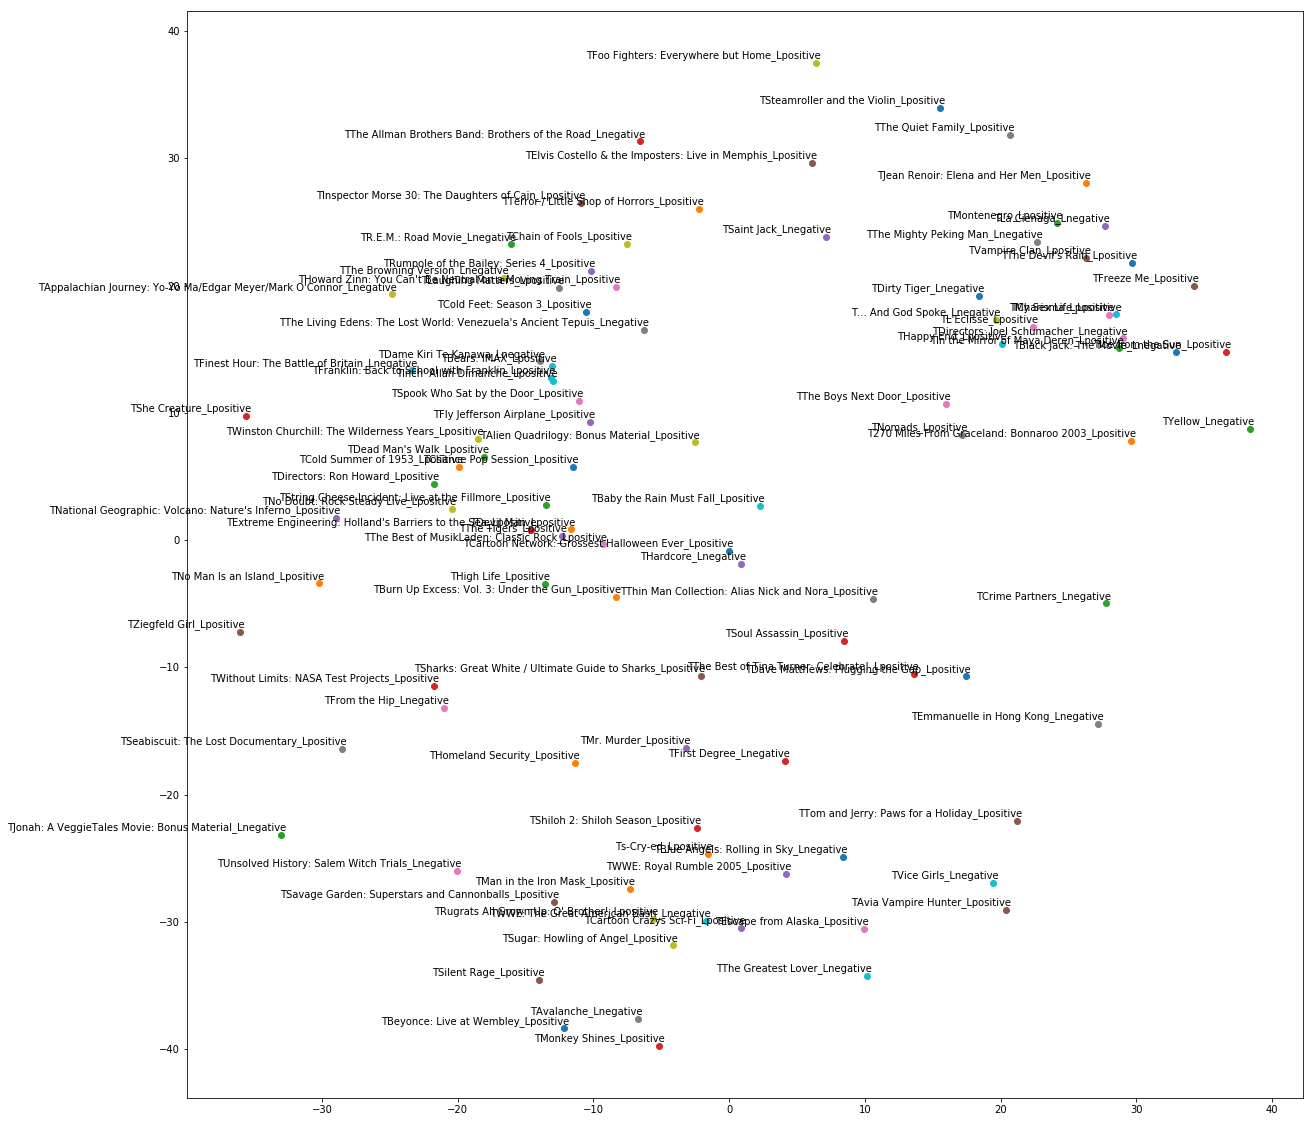

In [81]:
# plot a random number of movies
NUM_MOVIES_PLOT = 100

plt.figure(figsize=(20, 20)) 
for i, row in movie_df.iterrows():
    if i == NUM_MOVIES_PLOT:
        break
    plt.scatter(row['x_Lnetwork_Dtsne'], row['y_Lnetwork_Dtsne'])
    plt.annotate(row['annotate'],
                 xy=(row['x_Lnetwork_Dtsne'], row['y_Lnetwork_Dtsne']),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

### Bert Pretrained Embeddings

In [85]:
# filter bert's movie embeddings for the movies in pred_df

movie_ids = pred_df['movie_id'].unique()
movie_embeddings = json.load(open(MOVIE_TITLES_BERT_COMPS_FN))
movie_embeddings = np.array([np.array(v) for k, v in movie_embeddings.items() if int(k) in movie_ids])
print(movie_embeddings.shape)

movieid2idx = {movie_id: i for i, movie_id in enumerate(movie_ids)}
print(len(movieid2idx))

(4112, 768)
4112


In [86]:
# Dimensionality reduction by T-SNE

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=1000, metric="cosine", n_components=2)

%time embs = tsne.fit_transform(movie_embeddings)

CPU times: user 53.2 s, sys: 2.66 s, total: 55.9 s
Wall time: 55.4 s


In [87]:
print(embs.shape)

for prefix, pos in [('x', 0), ('y', 1)]:
    pred_df['{}_Lptb_Dtsne'.format(prefix)] = pred_df['movie_id'].apply(lambda x: embs[movieid2idx[x], pos])

(4112, 2)


In [89]:
cols = ['movie_id', 'x_Lptb_Dtsne', 'y_Lptb_Dtsne', 'movie_title', 'label']
tmp = pred_df.groupby('movie_id')['label'].nunique().rename('num_label').reset_index()
mask = tmp['num_label'] == 1
uni_movies = tmp.loc[mask, 'movie_id'].tolist()
mask = pred_df['movie_id'].isin(uni_movies)
movie_df = pred_df.loc[mask, cols]
movie_df.drop_duplicates(inplace=True)
movie_df.reset_index(drop=True, inplace=True)
movie_df['annotate'] = list(map(lambda x, y: 'T' + x + '_L' + y, movie_df['movie_title'], movie_df['label']))
movie_df = movie_df.sample(frac=1.).reset_index(drop=True)
del tmp, uni_movies

print(movie_df.shape)
print(movie_df['movie_id'].nunique())
print(movie_df['label'].value_counts())
movie_df.head()

(1062, 6)
1062
positive    796
negative    266
Name: label, dtype: int64


,movie_id,x_Lptb_Dtsne,y_Lptb_Dtsne,movie_title,label,annotate
0,2213,9.399045,-37.691071,Where the Day Takes You,positive,TWhere the Day Takes You_Lpositive
1,538,41.194759,54.428463,Rumpole of the Bailey: Series 4,positive,TRumpole of the Bailey: Series 4_Lpositive
2,968,41.792011,22.055193,Stripteaser,positive,TStripteaser_Lpositive
3,3584,34.907169,44.289158,Dead or Alive Final,negative,TDead or Alive Final_Lnegative
4,2241,2.372343,-37.469040,Night Caller from Outer Space,positive,TNight Caller from Outer Space_Lpositive


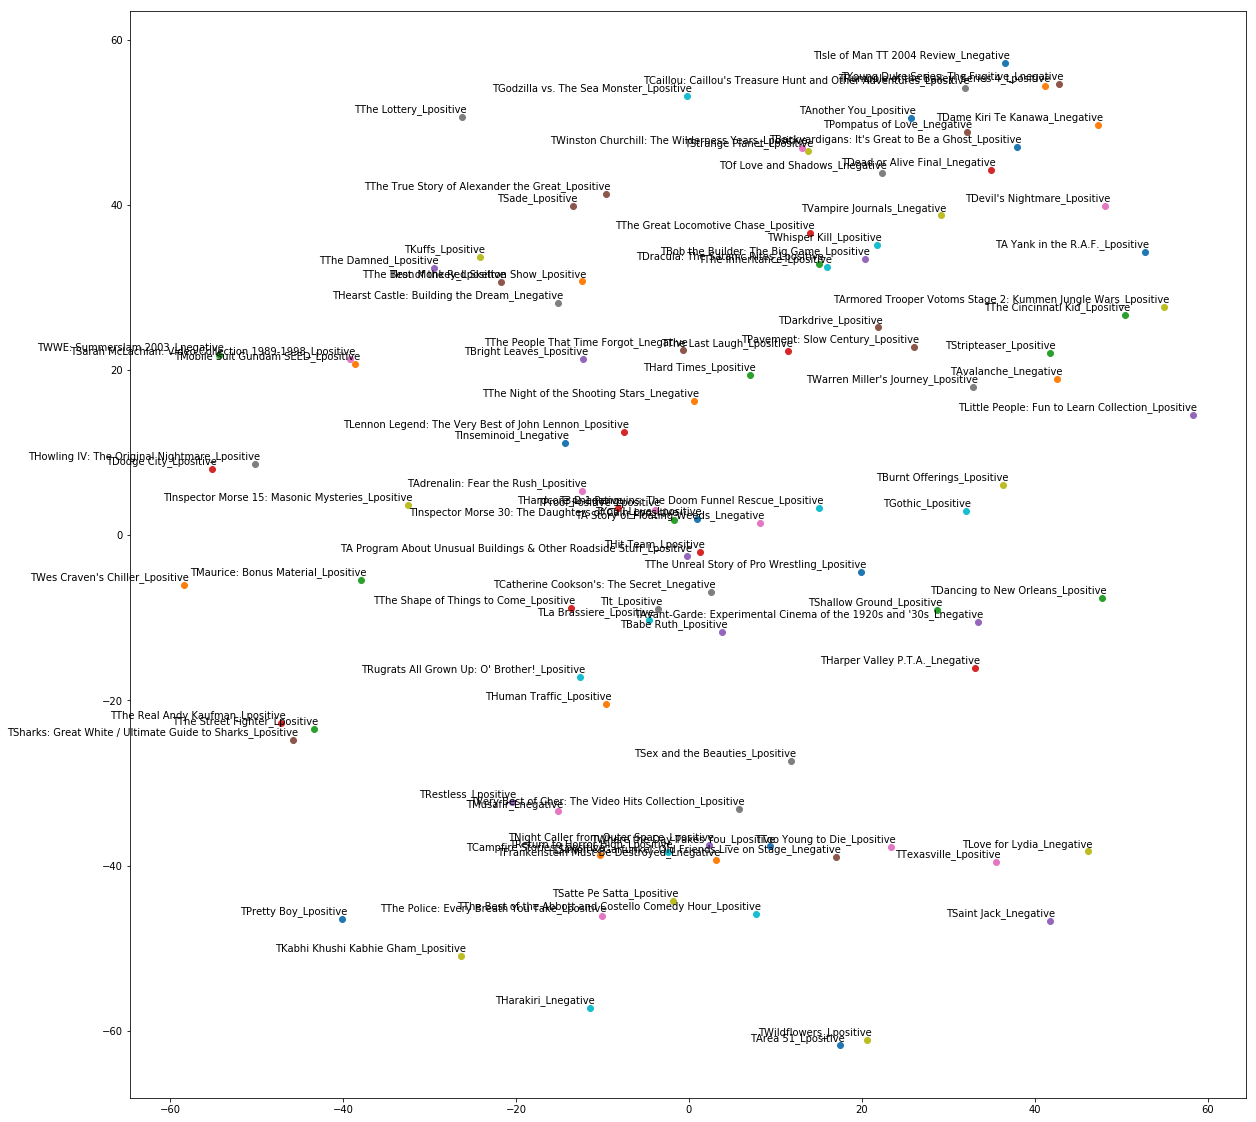

In [92]:
# plot a random number of movies
NUM_MOVIES_PLOT = 100

plt.figure(figsize=(20, 20)) 
for i, row in movie_df.iterrows():
    if i == NUM_MOVIES_PLOT:
        break
    plt.scatter(row['x_Lptb_Dtsne'], row['y_Lptb_Dtsne'])
    plt.annotate(row['annotate'],
                 xy=(row['x_Lptb_Dtsne'], row['y_Lptb_Dtsne']),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()